# pvlib-Python Forecasting (Denver, CO)
### Install Standard Release 

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1)


In [3]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165). 
!pip install cftime==1.1.2


# Try to save Excel
!pip install openpyxl

In [4]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
%matplotlib inline

# Specify Location (Albuiquerque, NM)
latitude, longitude, tz = 39.7, -105.2, 'US/Mountain'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=6)
irrad_vars = ['ghi','dni','dhi']

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [5]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [6]:
pytz.country_timezones('US')

['America/New_York',
 'America/Detroit',
 'America/Kentucky/Louisville',
 'America/Kentucky/Monticello',
 'America/Indiana/Indianapolis',
 'America/Indiana/Vincennes',
 'America/Indiana/Winamac',
 'America/Indiana/Marengo',
 'America/Indiana/Petersburg',
 'America/Indiana/Vevay',
 'America/Chicago',
 'America/Indiana/Tell_City',
 'America/Indiana/Knox',
 'America/Menominee',
 'America/North_Dakota/Center',
 'America/North_Dakota/New_Salem',
 'America/North_Dakota/Beulah',
 'America/Denver',
 'America/Boise',
 'America/Phoenix',
 'America/Los_Angeles',
 'America/Anchorage',
 'America/Juneau',
 'America/Sitka',
 'America/Metlakatla',
 'America/Yakutat',
 'America/Nome',
 'America/Adak',
 'Pacific/Honolulu']

In [7]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average  \
2020-05-12 06:00:00-06:00                                               99.0             
2020-05-12 09:00:00-06:00                                               84.0             
2020-05-12 12:00:00-06:00                                               84.0             
2020-05-12 15:00:00-06:00                                               21.0             
2020-05-12 18:00:00-06:00                                               11.0             

                           Downward_Short-Wave_Radiation_Flux_surface_Mixed_intervals_Average  \
2020-05-12 06:00:00-06:00                                               44.0                    
2020-05-12 09:00:00-06:00                                                0.0                    
2020-05-12 12:00:00-06:00                                                0.0                    
2020-05-12 15:00:00-06:00                                              

### Process Data with pvlib

In [8]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-05-12 06:00:00-06:00   6.769012    2.545067    0.326044    0.000000   
2020-05-12 09:00:00-06:00   2.592865    1.622315  230.207649   26.023199   
2020-05-12 12:00:00-06:00   4.398254    3.280066  402.842946   33.470418   
2020-05-12 15:00:00-06:00  16.360718    2.247578  687.651842  422.046647   
2020-05-12 18:00:00-06:00  34.659393    1.469482  274.026584  385.580061   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-12 06:00:00-06:00    0.326044          99.0         6.0        68.0   
2020-05-12 09:00:00-06:00  215.269048          84.0         0.0        80.0   
2020-05-12 12:00:00-06:00  372.418708          84.0         0.0        71.0   
2020-05-12 15:00:00-06:00  337.616824          21.0         0.0        19.0   
2020-05-12 18:00:00-06:00  126.664401          11.0         0.0        10.0   

                           high_clouds  
2020-05-12 06:00:00-06:00  

### GFS'S Class

In [9]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-05-12 06:00:00-06:00   6.769012    2.545067    0.326044    0.000000   
2020-05-12 09:00:00-06:00   2.592865    1.622315  230.207649   26.023199   
2020-05-12 12:00:00-06:00   4.398254    3.280066  402.842946   33.470418   
2020-05-12 15:00:00-06:00  16.360718    2.247578  687.651842  422.046647   
2020-05-12 18:00:00-06:00  34.659393    1.469482  274.026584  385.580061   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-12 06:00:00-06:00    0.326044          99.0         6.0        68.0   
2020-05-12 09:00:00-06:00  215.269048          84.0         0.0        80.0   
2020-05-12 12:00:00-06:00  372.418708          84.0         0.0        71.0   
2020-05-12 15:00:00-06:00  337.616824          21.0         0.0        19.0   
2020-05-12 18:00:00-06:00  126.664401          11.0         0.0        10.0   

                           high_clouds  
2020-05-12 06:00:00-06:00  

## Cloud Cover & Radiation

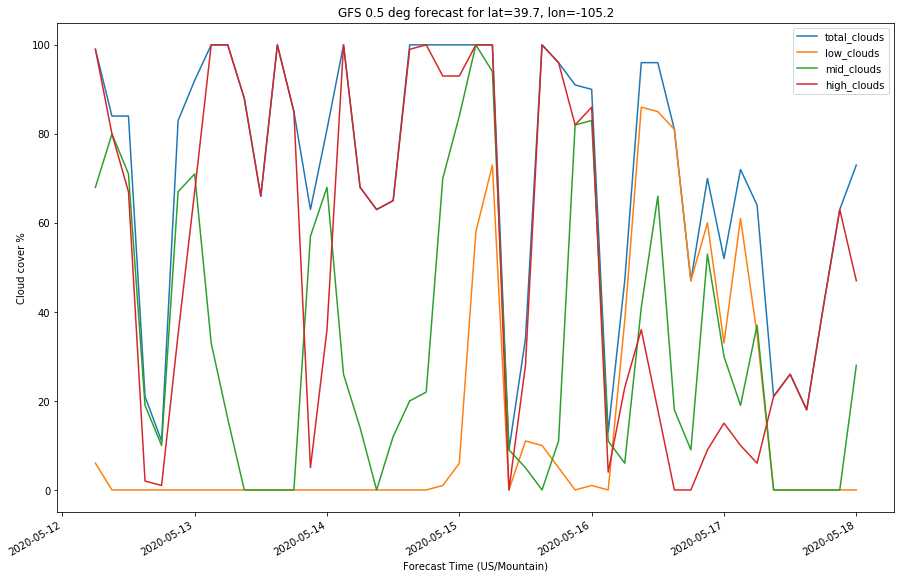

In [10]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

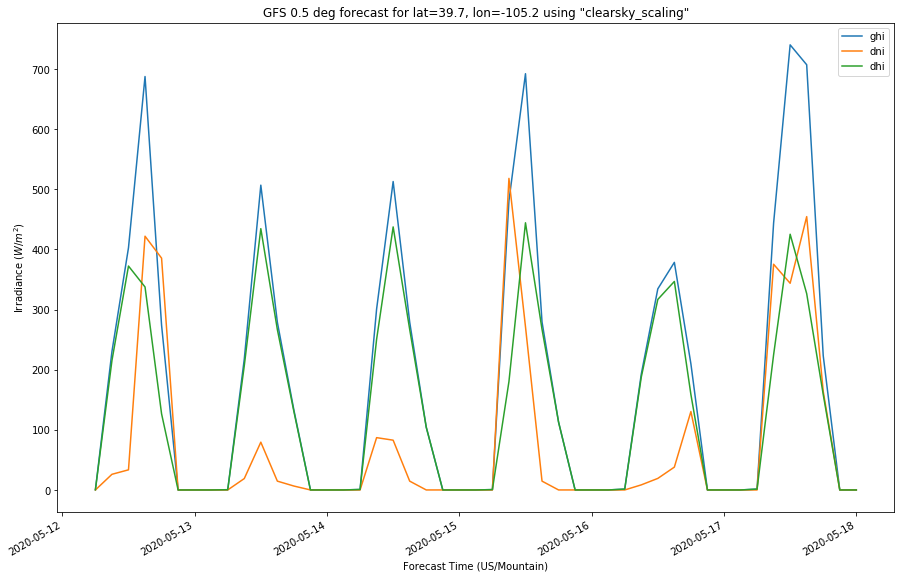

In [11]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

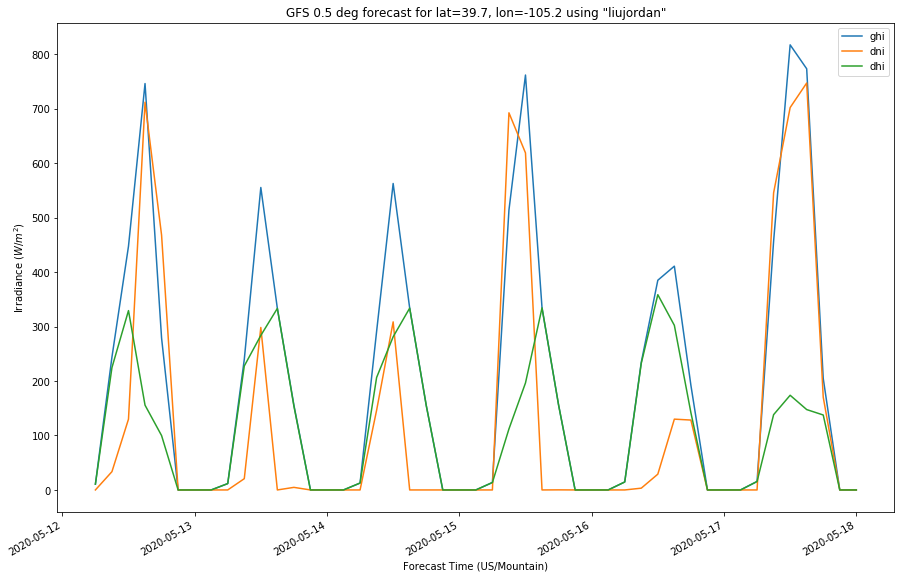

In [12]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

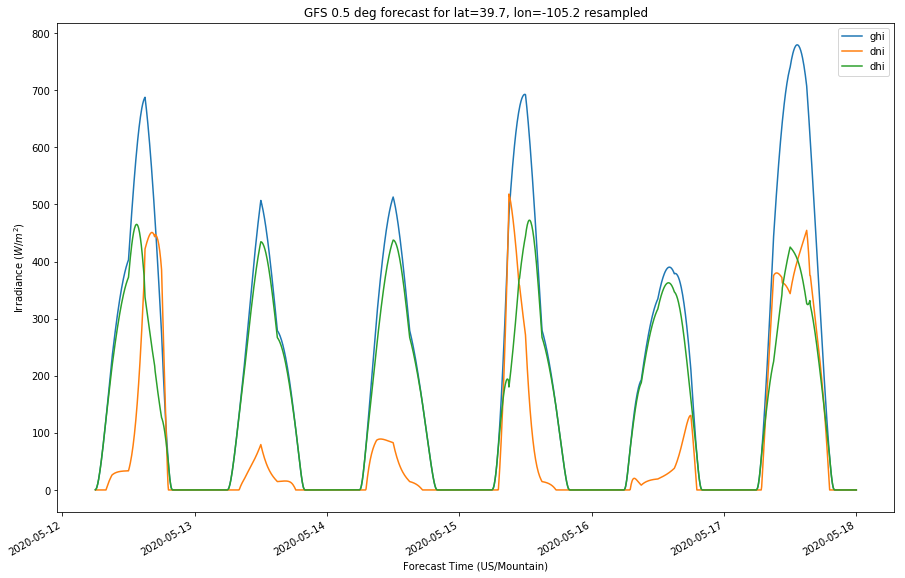

In [13]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

## Weather Models
### GFS
- The Global Forecast System is the US model that provides forecast for the entire globe (6hr update)
### HRRR

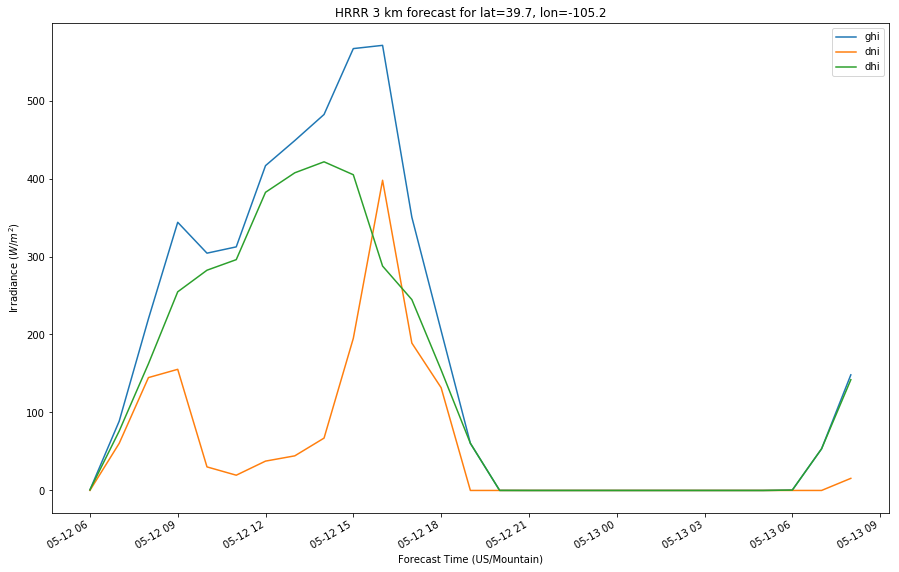

In [21]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### RAP

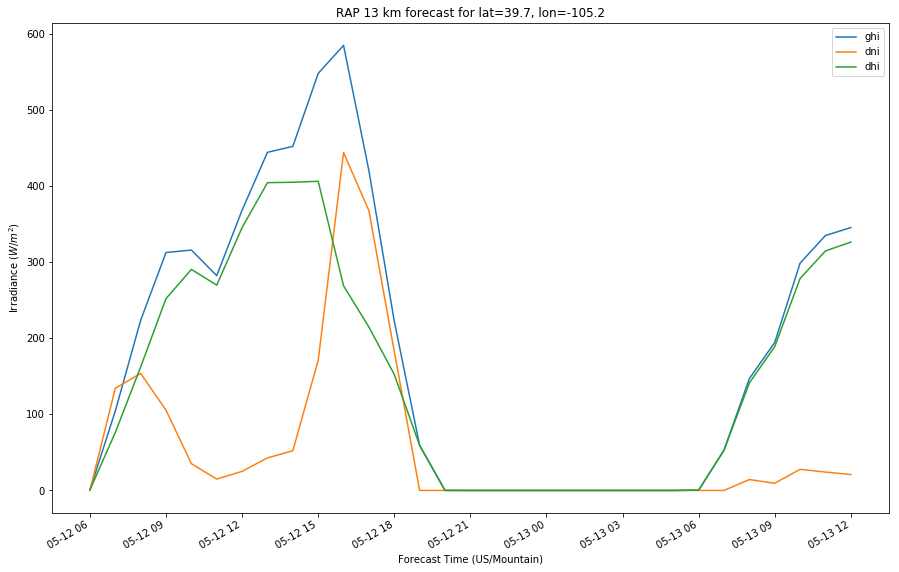

In [22]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

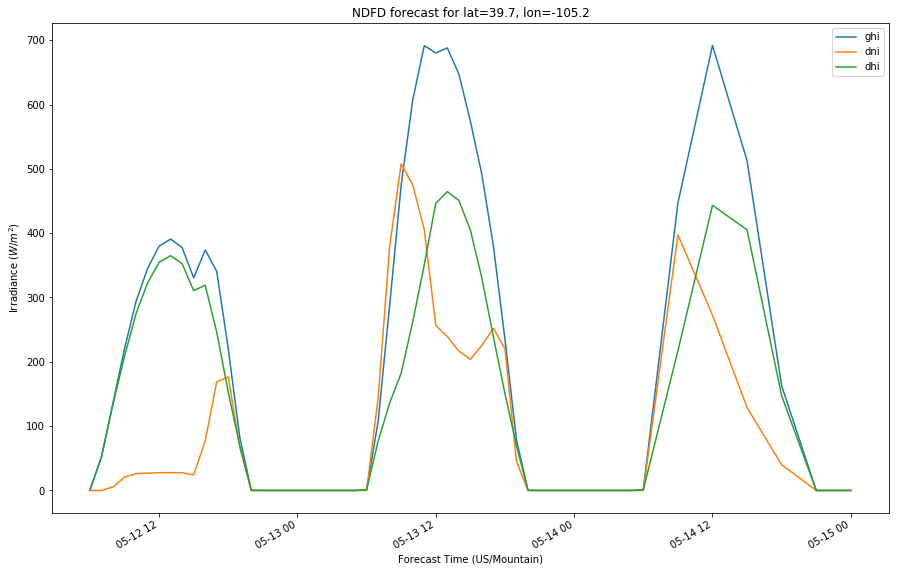

In [23]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

# PV Power Forecast

In [24]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## ModelChain Attributes

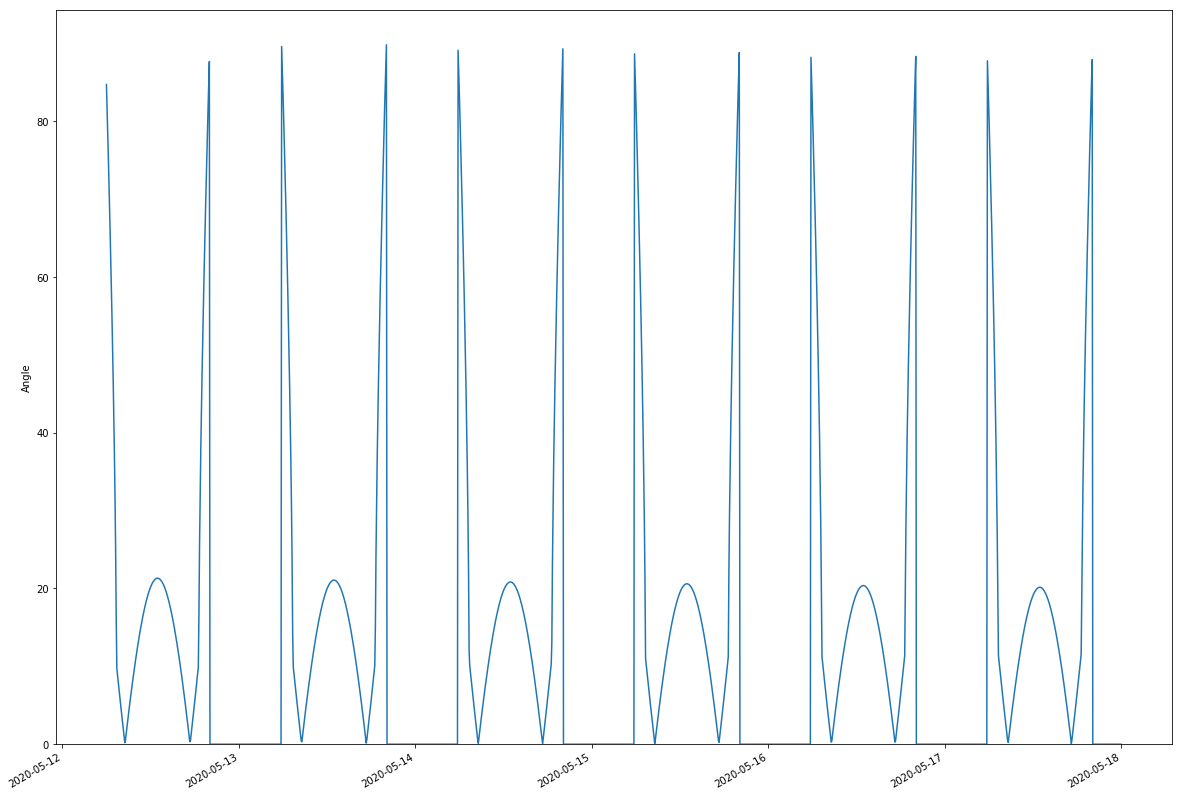

In [25]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

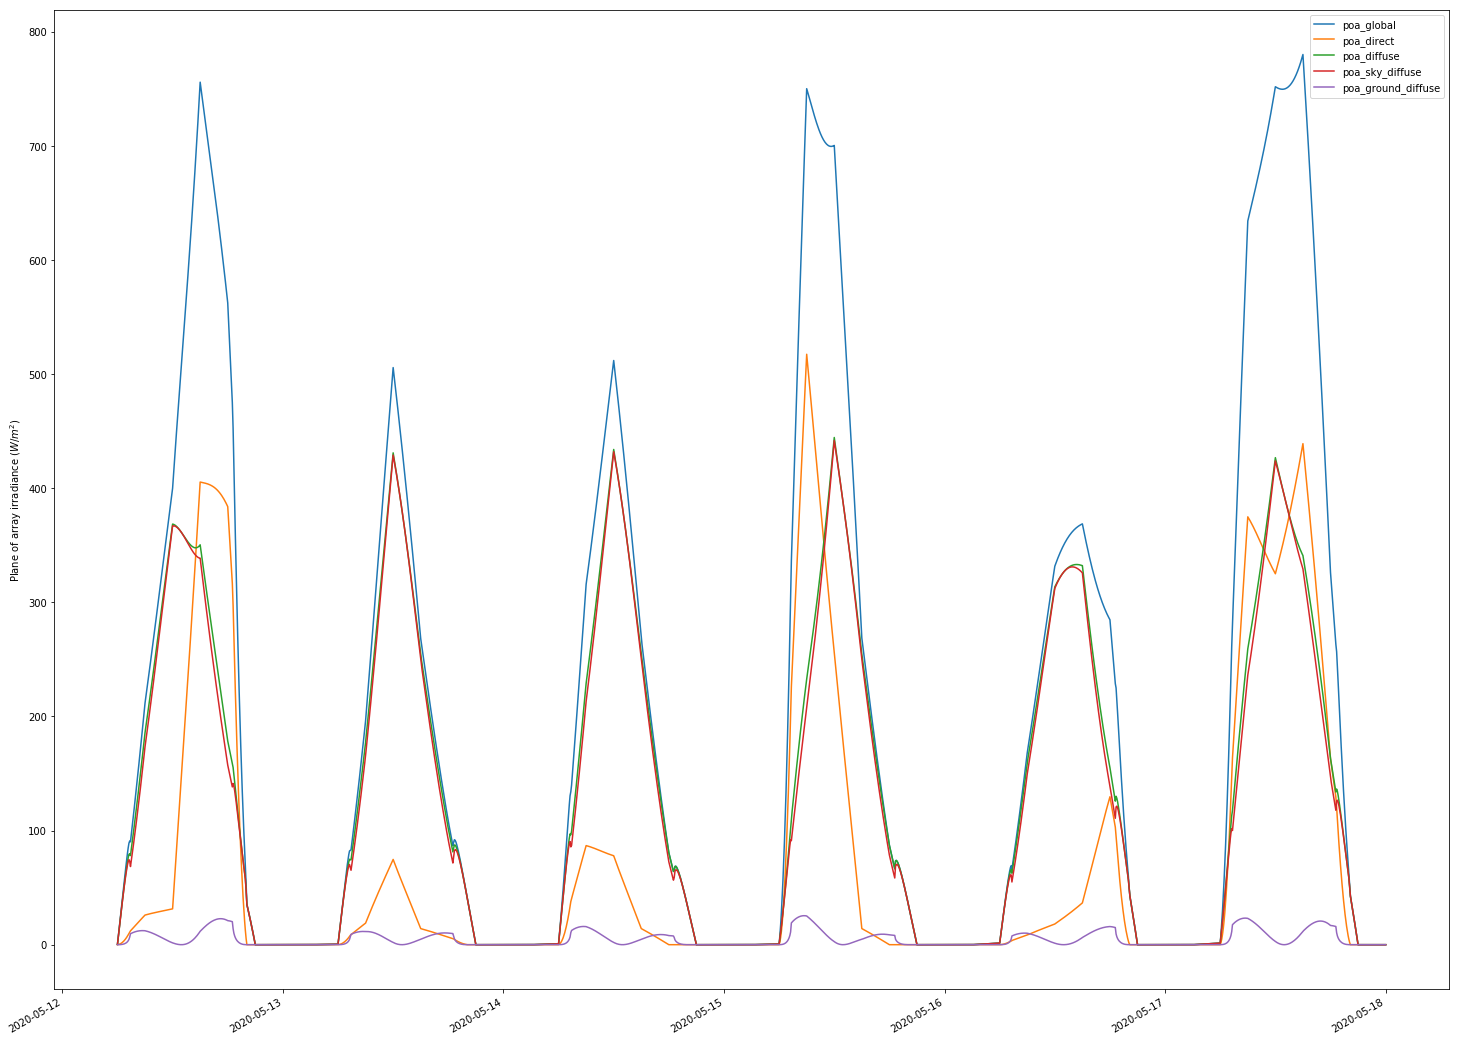

In [26]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

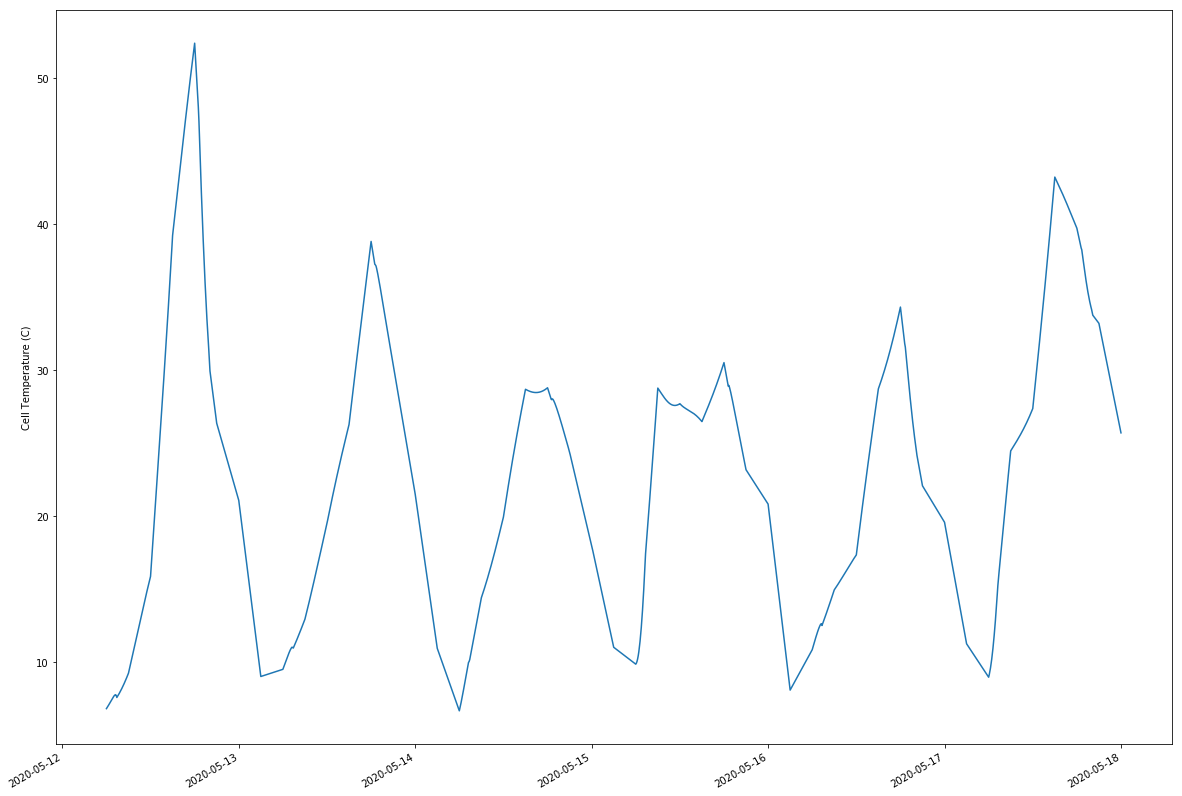

In [27]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

## MC DC Power

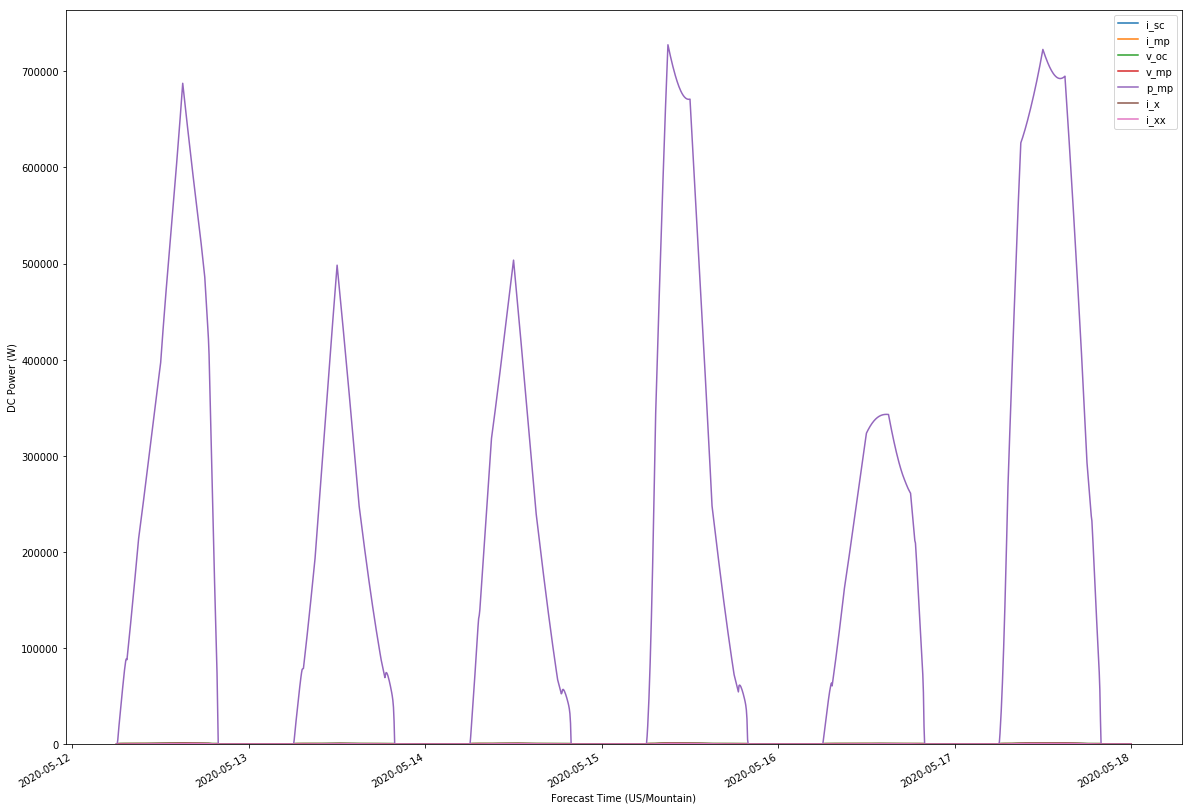

In [28]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [29]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,503.003700,451.898734,789.394093,645.619165,311184.005740,490.720840,340.322955
std,343.637936,307.230859,159.280640,139.962855,214897.403032,335.571186,223.522074
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,209.698432,189.066373,784.573424,636.214383,124329.254249,204.326308,148.921293
50%,461.622346,415.233100,827.448301,683.816261,286520.397355,450.060290,320.438008
75%,733.935691,660.452950,859.125438,713.345812,465690.267306,716.012377,496.604220
max,1188.472314,1060.224630,871.934862,734.155100,727595.688614,1160.650496,770.505108


In [30]:
mc.dc.fillna(0)

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
2020-05-12 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-12 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-12 06:10:00-06:00,11.186525,10.156463,708.375088,433.407233,4401.884375,10.894919,8.085079
2020-05-12 06:15:00-06:00,25.155844,22.836465,747.616019,531.421737,12135.793759,24.500896,18.158884
2020-05-12 06:20:00-06:00,37.108321,33.683025,766.297998,572.704635,19290.424745,36.143198,26.758393
2020-05-12 06:25:00-06:00,47.980667,43.547143,778.551856,597.903604,26036.993755,46.733968,34.564859
2020-05-12 06:30:00-06:00,58.377258,52.977602,787.838705,616.003850,32634.406995,56.861811,42.015547
2020-05-12 06:35:00-06:00,68.566022,62.217633,795.406957,630.112191,39204.088867,66.787679,49.303848
2020-05-12 06:40:00-06:00,78.632470,71.344882,801.813319,641.598766,45774.788247,76.594854,56.491579
2020-05-12 06:45:00-06:00,88.574469,80.357494,807.350872,651.186765,52327.736397,86.281241,63.577697


In [31]:
mc.dc.fillna(0).to_csv('5 min DC 2nd.csv', encoding='utf-8')

## MC AC Power

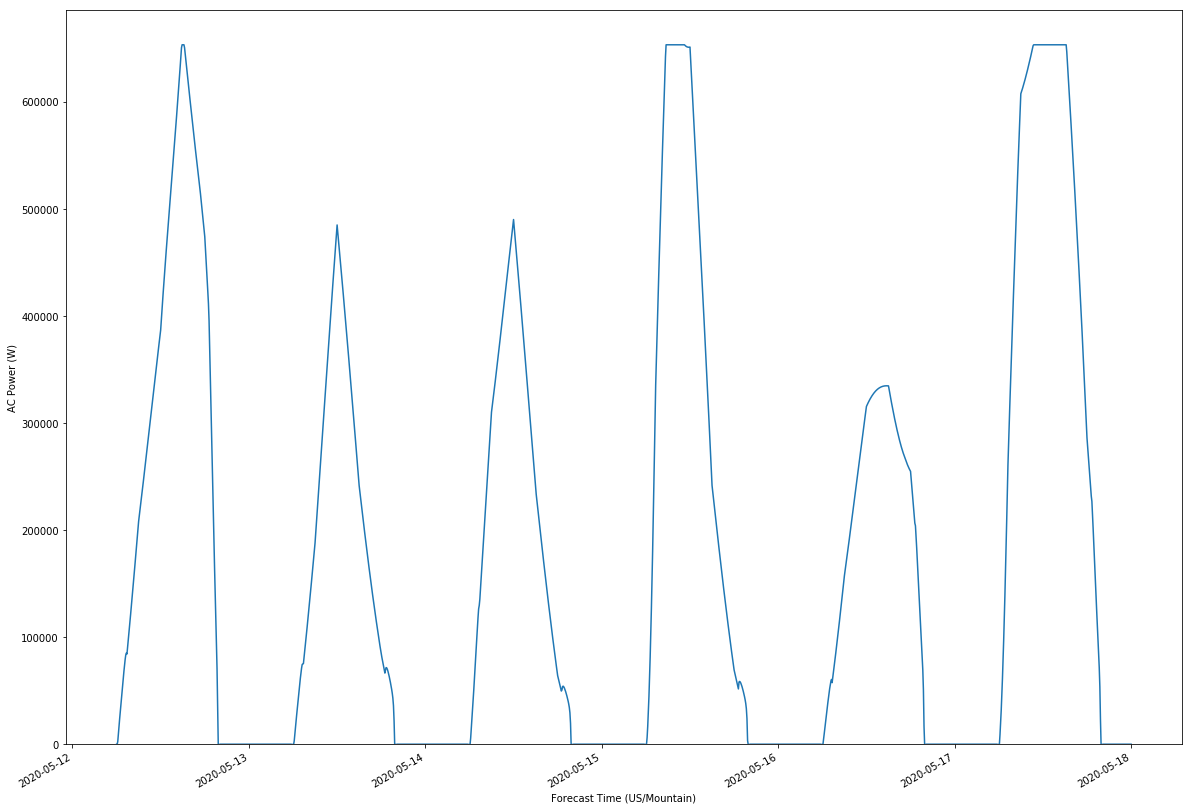

In [32]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [33]:
mc.ac.describe()

count      1029.000000
mean     300396.665522
std      205464.622302
min        -195.900000
25%      120169.421123
50%      279520.969776
75%      453494.341947
max      653000.000000
dtype: float64

In [34]:
mc.ac.fillna(0)

2020-05-12 06:00:00-06:00      -195.900000
2020-05-12 06:05:00-06:00      -195.900000
2020-05-12 06:10:00-06:00      2652.196779
2020-05-12 06:15:00-06:00      9879.740404
2020-05-12 06:20:00-06:00     16789.416083
2020-05-12 06:25:00-06:00     23365.205403
2020-05-12 06:30:00-06:00     29823.034500
2020-05-12 06:35:00-06:00     36269.152380
2020-05-12 06:40:00-06:00     42725.790031
2020-05-12 06:45:00-06:00     49171.052526
2020-05-12 06:50:00-06:00     55560.294193
2020-05-12 06:55:00-06:00     61832.855876
2020-05-12 07:00:00-06:00     67907.801064
2020-05-12 07:05:00-06:00     73666.494775
2020-05-12 07:10:00-06:00     78906.947024
2020-05-12 07:15:00-06:00     83201.627311
2020-05-12 07:20:00-06:00     85099.332575
2020-05-12 07:25:00-06:00     84248.154164
2020-05-12 07:30:00-06:00     90321.646198
2020-05-12 07:35:00-06:00     96450.732797
2020-05-12 07:40:00-06:00    102633.904265
2020-05-12 07:45:00-06:00    108870.005001
2020-05-12 07:50:00-06:00    115158.152904
2020-05-12 

In [35]:
mc.ac.fillna(0).to_csv('5 min AC 2nd.csv', encoding='utf-8')

In [37]:
resampled_irrads

,ghi,dni,dhi
2020-05-12 06:00:00-06:00,0.326044,0.000000,0.326044
2020-05-12 06:05:00-06:00,1.036491,0.000000,1.036491
2020-05-12 06:10:00-06:00,2.362048,0.000000,2.362048
2020-05-12 06:15:00-06:00,4.374745,0.000000,4.374745
2020-05-12 06:20:00-06:00,7.065167,0.000000,7.065167
2020-05-12 06:25:00-06:00,10.380902,0.000000,10.380902
2020-05-12 06:30:00-06:00,14.254478,0.000000,14.254478
2020-05-12 06:35:00-06:00,18.618299,0.000000,18.618299
2020-05-12 06:40:00-06:00,23.411073,0.000000,23.411073
2020-05-12 06:45:00-06:00,28.579698,0.000000,28.579698


In [38]:
resampled_irrads.to_csv('5 min Irrad 2nd.csv', encoding='utf-8')